In [1]:
import subprocess

def install(name):
    subprocess.call(['pip', 'install', name])

install('nibabel')
install('scikit-learn')

In [2]:
import numpy as np
import os
import glob
import sys
import nibabel as nib
import logging
import matplotlib.pyplot as plt

# Importing our model
MY_UTILS_PATH = "../src/"
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import cs_models_sc as fsnet
import tensorflow as tf
# Importing callbacks and data augmentation utils

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import  Adam

physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
#input paramters
H,W = (512,512)
Hpad = (8 - (H%8))//2
Wpad = (8 - (W%8))//2

In [4]:
#file ids for all training pairs
training_files = np.loadtxt('../data/train.txt', dtype=str)
validation_files = np.loadtxt('../data/val.txt', dtype=str)

In [5]:
ref_path = '../../../data/brain-cancer/'
next_path = '../data/zero_filled_rec/10x/'
ref_reg_path = '../data/reference_reg_10x/'

In [6]:
#pathes to training data
train_previous_files = [ref_reg_path + 'elastic_' + moving[:-4] + '_' + fixed for moving, fixed in zip(training_files[:,0],training_files[:,1])]
train_follow_up_files = [ref_path + file for file in training_files[:,1]]
#train_follow_up_files = [next_path + file for file in training_files[:,1]]
train_reference_files = [ref_path + file for file in training_files[:,1]]

In [7]:
#pathes to validation data
val_previous_files = [ref_reg_path + 'elastic_' + moving[:-4] + '_' + fixed for moving, fixed in zip(validation_files[:,0],validation_files[:,1])]
val_follow_up_files = [ref_path + file for file in validation_files[:,1]]
val_reference_files = [ref_path + file for file in validation_files[:,1]]

Need to load 3 inputs: [kspace, previous_rec, under_masks]
Need one output: [ref]

load kspace of zero-filled/follow-up files where imag and real channels separate

In [8]:
train_zero_filled = []
train_previous = []
train_ref = []
for ii, file in enumerate(train_follow_up_files):
    img = nib.load(file)
    zero_filled_rec = np.swapaxes(img.get_fdata(),0,2)
    zero_filled_rec = zero_filled_rec / np.abs(zero_filled_rec).max()
    #convert zero filled reconstruction to kspace
    f = np.fft.fft2(zero_filled_rec)
    zero_filled_kspace = np.zeros((*zero_filled_rec.shape,2))
    zero_filled_kspace[:,:,:,0] = f.real
    zero_filled_kspace[:,:,:,1] = f.imag
    train_zero_filled.append(zero_filled_kspace)
    #load previous registered reconstruction
    img2 = nib.load(train_previous_files[ii])
    previous_rec = np.swapaxes(img2.get_fdata(),0,2)[...,np.newaxis]
    previous_rec = previous_rec / np.abs(previous_rec).max()
    train_previous.append(previous_rec)
    #load reference reconstruction
    img3 = nib.load(train_reference_files[ii])
    ref_rec = np.swapaxes(img3.get_fdata(),0,2)[:,:,:,np.newaxis]
    ref_rec = ref_rec / ref_rec.max()
    train_ref.append(ref_rec)
train_zero_filled = np.concatenate(train_zero_filled,axis=0)
train_previous = np.concatenate(train_previous)
train_ref = np.concatenate(train_ref)

In [9]:
print(train_zero_filled.shape, train_previous.shape, train_ref.shape)

(753, 512, 512, 2) (753, 512, 512, 1) (753, 512, 512, 1)


In [10]:
val_zero_filled = []
val_previous = []
val_ref = []
for ii, file in enumerate(val_follow_up_files):
    img = nib.load(file)
    zero_filled_rec = np.swapaxes(img.get_fdata(),0,2)
    zero_filled_rec = zero_filled_rec / np.abs(zero_filled_rec).max()
    #convert zero filled reconstruction to kspace
    f = np.fft.fft2(zero_filled_rec)
    zero_filled_kspace = np.zeros((*zero_filled_rec.shape,2))
    zero_filled_kspace[:,:,:,0] = f.real
    zero_filled_kspace[:,:,:,1] = f.imag
    val_zero_filled.append(zero_filled_kspace)
    #load previous registered reconstruction
    img2 = nib.load(val_previous_files[ii])
    previous_rec = np.swapaxes(img2.get_fdata(),0,2)[...,np.newaxis]
    previous_rec = previous_rec / np.abs(previous_rec).max()
    val_previous.append(previous_rec)
    #load reference reconstruction
    img3 = nib.load(val_reference_files[ii])
    ref_rec = np.swapaxes(img3.get_fdata(),0,2)[:,:,:,np.newaxis]
    ref_rec = ref_rec / ref_rec.max()
    val_ref.append(ref_rec)
val_zero_filled = np.concatenate(val_zero_filled,axis=0)
val_previous = np.concatenate(val_previous)
val_ref = np.concatenate(val_ref)


In [11]:
print(train_zero_filled.shape, train_previous.shape, train_ref.shape)

(753, 512, 512, 2) (753, 512, 512, 1) (753, 512, 512, 1)


In [12]:
#generate masks for k-space data of zero_filled reconstruction
#there may be a better way of implementing this but will try this first
# Loading sampling patterns. Notice that here we are using uncentred k-space
var_sampling_mask = np.fft.fftshift(~np.load("../data/sampling_masks/R10_512x512_poisson_center_true_radius_40_r_2.66.npy"),axes=(1,2))
var_sampling_mask = np.concatenate((var_sampling_mask[:,:,:,np.newaxis],var_sampling_mask[:,:,:,np.newaxis]),\
                               
                                   axis = -1)
# Undersampling the training set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),train_zero_filled.shape[0],replace = True)
train_var_sampling_mask = (var_sampling_mask[indexes])

# Undersampling the validation set
indexes = np.random.choice(np.arange(var_sampling_mask.shape[0],dtype =int),val_zero_filled.shape[0],replace = True)
val_var_sampling_mask = (var_sampling_mask[indexes])


In [13]:
print(train_var_sampling_mask.shape)

(753, 512, 512, 2)


In [14]:
train_zero_filled.shape

(753, 512, 512, 2)

In [15]:
train_zero_filled[train_var_sampling_mask] = 0
val_zero_filled[val_var_sampling_mask] = 0

In [ ]:
np.fft.ifft2(train_zero_filled[...,0] + 1j*train_zero_filled[...,1])

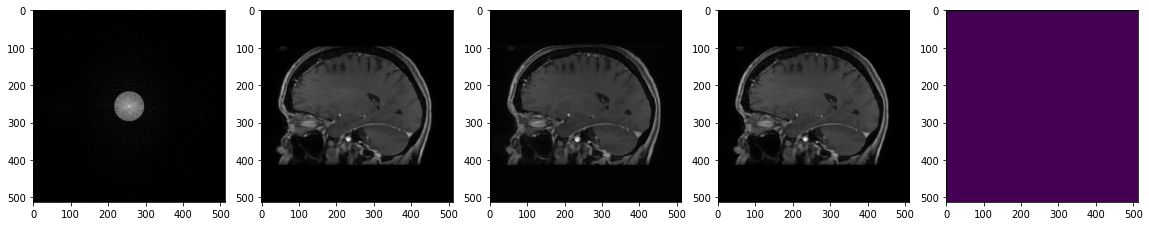

In [16]:
plt.figure(figsize=(16,4))
plt.subplot(151)
plt.imshow(np.log(1+np.abs(np.fft.fftshift(train_zero_filled[100,:,:,0]+1j*train_zero_filled[100,:,:,1]))), cmap='gray')
plt.subplot(152)
plt.imshow(train_zero_filled[100,:,:],cmap='gray')
plt.subplot(153)
plt.imshow(previous_rec[100,:,:,0], cmap='gray')
plt.subplot(154)
plt.imshow(ref_rec[100,:,:,0],cmap='gray')
plt.subplot(155)
plt.imshow(np.abs(ref_rec[100,:,:,0] - zero_filled_rec[100,:,:]))
plt.tight_layout()

In [17]:
epochs = 100
batch_size= 6
os.makedirs('../models/', exist_ok=True)
model_name = "../models/end-to-end-10x.hdf5"

# Early stopping callback to shut down training after
# 5 epochs with no improvement
earlyStopping = EarlyStopping(monitor='val_loss',
                                       patience=5, 
                                       verbose=0, mode='min')

# Checkpoint callback to save model  along the epochs
checkpoint = ModelCheckpoint(model_name, mode = 'min', \
                         monitor='val_loss',verbose=0,\
                         save_best_only=True, save_weights_only = True)

In [18]:
# Training our model
model = fsnet.deep_cascade_flat_unrolled("i", H=H,W=W,Hpad=Hpad,Wpad=Wpad,channels=2)
opt = Adam(learning_rate = 1e-4,decay = 1e-4)
model.compile(loss = ['mse','mse'],weights=[0.5,0.5],optimizer=opt)
print(model.summary())

hist = model.fit([train_zero_filled, train_previous,train_var_sampling_mask],
                 [train_ref, train_ref],
             epochs=epochs,
             steps_per_epoch=train_ref.shape[0]//batch_size,
             verbose=1,
             validation_data= ([val_zero_filled,val_previous,val_var_sampling_mask],[val_ref, val_ref]),
             callbacks=[checkpoint,earlyStopping])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 2) 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 512, 512, 2)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 512, 512, 48) 912         lambda[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 512, 512, 48) 0           conv2d[0][0]                     
______________________________________________________________________________________________

Epoch 1/100
 29/125 [=====>........................] - ETA: 29s - loss: 3285.4329

KeyboardInterrupt: 